# Example: Graph generation from a gene

This notebook will show you how to use the tool to generate a KG on the underlying data.

In [1]:
import os
import time

start_time = time.time()

current_dir = os.getcwd()

os.chdir(f"{current_dir}/..")

# Set the current working directory
current_dir = os.getcwd()
print("Current directory:", current_dir)

Current directory: /home/javi/code/pyBiodatafuse-2


In [2]:
# Import modules
import pickle

import pandas as pd
from IPython.display import Image, Markdown, display

from pyBiodatafuse import id_mapper
from pyBiodatafuse.annotators import (
    bgee,
    disgenet,
    minerva,
    molmedb,
    opentargets,
    pubchem,
    stringdb,
    wikipathways,
)
from pyBiodatafuse.constants import DISGENET_DISEASE_COL
from pyBiodatafuse.graph import generator
from pyBiodatafuse.graph.rdf import BDFGraph
from pyBiodatafuse.utils import (
    combine_sources,
    create_harmonized_input_file,
    create_or_append_to_metadata,
)

### Load the input list and convert it to a dataframe

In [3]:
genes_of_interest = """SETD1A
CUL1
XPO7
GRIA3
GRIN2A
RB1CC1
"""

gene_list = genes_of_interest.split("\n")
len(gene_list)

7

In [4]:
data_input = pd.DataFrame(gene_list, columns=["identifier"])
data_input.head()

,identifier
0,SETD1A
1,CUL1
2,XPO7
3,GRIA3
4,GRIN2A


### Entity resolution using BridgeDB

In [5]:
os.makedirs("examples/data", exist_ok=True)
os.makedirs("examples/results/gene_to_graph_workflow", exist_ok=True)

In [6]:
pickle_path = os.path.join(os.getcwd(), "examples/data/example_gene_list.pkl")
metadata_path = os.path.join(os.getcwd(), "examples/data/example_gene_list_metadata.pkl")

if not os.path.exists(pickle_path):
    bridgedb_df, bridgedb_metadata = id_mapper.bridgedb_xref(
        identifiers=data_input,
        input_species="Human",
        input_datasource="HGNC",
        output_datasource="All",
    )
    bridgedb_df.to_pickle(pickle_path)
    with open(metadata_path, "wb") as file:
        pickle.dump(bridgedb_metadata, file)
else:
    bridgedb_df = pd.read_pickle(pickle_path)
    with open(metadata_path, "rb") as file:
        bridgedb_metadata = pickle.load(file)

In [7]:
print("Number of genes with mapping in BridgeDb:", len(bridgedb_df["identifier"].unique()))
bridgedb_df.head()

Number of genes with mapping in BridgeDb: 6


,identifier,identifier.source,target,target.source
0,SETD1A,HGNC,C9J2Z9,Uniprot-TrEMBL
1,SETD1A,HGNC,ENSG00000099381,Ensembl
2,SETD1A,HGNC,HGNC:29010,HGNC Accession Number
3,SETD1A,HGNC,SETD1A,HGNC
4,SETD1A,HGNC,9739,NCBI Gene


### Gene expression from Bgee

In [8]:
bgee_path = os.path.join(os.getcwd(), "examples/data/example_bgee.pkl")
bgee_metadata_path = os.path.join(os.getcwd(), "examples/data/example_bgee_metadata.pkl")

if not os.path.exists(bgee_path):
    bgee_df, bgee_metadata = bgee.get_gene_expression(bridgedb_df=bridgedb_df)
    bgee_df.to_pickle(bgee_path)
    with open(bgee_metadata_path, "wb") as file:
        pickle.dump(bgee_metadata, file)
else:
    bgee_df = pd.read_pickle(bgee_path)
    with open(bgee_metadata_path, "rb") as file:
        bgee_metadata = pickle.load(file)

### Disease annotatation from DisGeNet


In [9]:
import dotenv

disgenet_api_key = dotenv.dotenv_values(".env")["DISGENET_API_KEY"]

In [10]:
disgenet_path = os.path.join(os.getcwd(), "examples/data/example_disgenet.pkl")
disgenet_metadata_path = os.path.join(os.getcwd(), "examples/data/example_disgenet_metadata.pkl")

if not os.path.exists(disgenet_path):
    disgenet_df, disgenet_metadata = disgenet.get_gene_disease(
        api_key=disgenet_api_key, bridgedb_df=bridgedb_df
    )

    disgenet_df.to_pickle(disgenet_path)
    with open(disgenet_metadata_path, "wb") as file:
        pickle.dump(disgenet_metadata, file)
else:
    disgenet_df = pd.read_pickle(disgenet_path)
    with open(disgenet_metadata_path, "rb") as file:
        disgenet_metadata = pickle.load(file)

Querying DisGeNET: 100%|██████████| 6/6 [00:03<00:00,  1.86it/s]


### Disease to compound annotation from OpenTargets

In [11]:
# Prepare the input to use DISGENET output as seed for OpenTargets
disease_mapping_df = create_harmonized_input_file(disgenet_df, DISGENET_DISEASE_COL, "EFO", "UMLS")
disease_mapping_df.head()

,identifier,identifier.source,target,target.source
0,UMLS_C0038325,UMLS,EFO_0004276,EFO
1,UMLS_C0036572,UMLS,EFO_0009853,EFO
2,UMLS_C1535926,UMLS,EFO_0010642,EFO
3,UMLS_C0011581,UMLS,EFO_0004257,EFO
4,UMLS_C0011581,UMLS,EFO_0008623,EFO


In [12]:
opentarget_path = os.path.join(os.getcwd(), "examples/data/example_opentarget_cmpd.pkl")
opentarget_metadata_path = os.path.join(
    os.getcwd(), "examples/data/example_opentarget_cmpd_metadata.pkl"
)

if not os.path.exists(opentarget_path):
    opentargets_df, opentargets_metadata = opentargets.get_disease_compound_interactions(
        disease_mapping_df
    )
    opentargets_df.to_pickle(opentarget_path)
    with open(opentarget_metadata_path, "wb") as file:
        pickle.dump(opentargets_metadata, file)
else:
    opentargets_df = pd.read_pickle(opentarget_path)
    with open(opentarget_metadata_path, "rb") as file:
        opentargets_metadata = pickle.load(file)

Mapping PubChem: 100%|██████████| 251/251 [01:51<00:00,  2.24it/s]
/home/javi/code/pyBiodatafuse-2/src/pyBiodatafuse/annotators/opentargets.py:1119: UserWarning: Not all values in column 'adverse_effect' have the correct type '<class 'dict'>'.
  check_columns_against_constants(


### Pathways from MINERVA

In [13]:
minerva_path = os.path.join(os.getcwd(), "examples/data/example_minerva.pkl")
minerva_metadata_path = os.path.join(os.getcwd(), "examples/data/example_minerva_metadata.pkl")

if not os.path.exists(minerva_path):
    minerva_df, minerva_metadata = minerva.get_gene_minerva_pathways(
        bridgedb_df, map_name="COVID19 Disease Map"
    )
    minerva_df.to_pickle(minerva_path)
    with open(minerva_metadata_path, "wb") as file:
        pickle.dump(minerva_metadata, file)

else:
    minerva_df = pd.read_pickle(minerva_path)
    with open(minerva_metadata_path, "rb") as file:
        minerva_metadata = pickle.load(file)

/tmp/ipykernel_205821/2116567606.py:5: UserWarning: There is no annotation for your input list in MINERVA, project COVID19 Disease Map.
  minerva_df, minerva_metadata = minerva.get_gene_minerva_pathways(


In [14]:
minerva_metadata

{'datasource': 'MINERVA',
 'metadata': {'source_version': '18.0.3'},
 'query': {'size': 6,
  'input_type': 'Ensembl',
  'MINERVA project': 'COVID19 Disease Map',
  'time': '0:01:08.205299',
  'date': '2024-11-14 15:18:15',
  'url': 'https://covid19map.elixir-luxembourg.org/minerva/'}}

### Pathways from WikiPathways

In [15]:
wikipathways_path = os.path.join(os.getcwd(), "examples/data/example_wikipathway.pkl")
wikipathways_metadata_path = os.path.join(
    os.getcwd(), "examples/data/example_wikipathway_metadata.pkl"
)

if not os.path.exists(wikipathways_path):
    wikipathways_df, wikipathways_metadata = wikipathways.get_gene_wikipathways(
        bridgedb_df=bridgedb_df
    )
    wikipathways_df.to_pickle(wikipathways_path)
    with open(wikipathways_metadata_path, "wb") as file:
        pickle.dump(wikipathways_metadata, file)

else:
    wikipathways_df = pd.read_pickle(wikipathways_path)
    with open(wikipathways_metadata_path, "rb") as file:
        wikipathways_metadata = pickle.load(file)

Querying WikiPathways: 100%|██████████| 1/1 [00:17<00:00, 17.21s/it]


### Reactome pathways from OpenTargets

In [16]:
opentargets_reactome_path = os.path.join(os.getcwd(), "examples/data/example_ot_reactome.pkl")
opentargets_reactome_metadata_path = os.path.join(
    os.getcwd(), "examples/data/example_ot_reactome_metadata.pkl"
)

if not os.path.exists(opentargets_reactome_path):
    opentargets_reactome_df, opentargets_reactome_metadata = opentargets.get_gene_reactome_pathways(
        bridgedb_df=bridgedb_df
    )
    opentargets_reactome_df.to_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "wb") as file:
        pickle.dump(opentargets_reactome_metadata, file)
else:
    opentargets_reactome_df = pd.read_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "rb") as file:
        opentargets_reactome_metadata = pickle.load(file)

Processing gene-pathway interactions: 100%|██████████| 6/6 [00:00<00:00, 453.32it/s]


### Gene Ontology from OpenTargets

In [17]:
opentargets_go_path = os.path.join(os.getcwd(), "examples/data/example_ot_go.pkl")
opentargets_go_metadata_path = os.path.join(os.getcwd(), "examples/data/example_ot_go_metadata.pkl")

if not os.path.exists(opentargets_go_path):
    opentargets_go_df, opentargets_go_metadata = opentargets.get_gene_go_process(
        bridgedb_df=bridgedb_df
    )
    opentargets_go_df.to_pickle(opentargets_go_path)
    with open(opentargets_go_metadata_path, "wb") as file:
        pickle.dump(opentargets_go_metadata, file)
else:
    opentargets_go_df = pd.read_pickle(opentargets_go_path)
    with open(opentargets_go_metadata_path, "rb") as file:
        opentargets_go_metadata = pickle.load(file)

Processing gene annotation: 100%|██████████| 6/6 [00:00<00:00, 296.47it/s]


### Compounds from OpenTarget

In [18]:
opentargets_gene_path = os.path.join(os.getcwd(), "examples/data/example_ot_gene_cmpd.pkl")
opentargets_gene_metadata_path = os.path.join(
    os.getcwd(), "examples/data/example_ot_gene_cmpd_metadata.pkl"
)

if not os.path.exists(opentargets_gene_path):
    opentargets_compound_df, opentargets_compound_metadata = (
        opentargets.get_gene_compound_interactions(bridgedb_df=bridgedb_df)
    )
    opentargets_compound_df.to_pickle(opentargets_gene_path)
    with open(opentargets_gene_metadata_path, "wb") as file:
        pickle.dump(opentargets_compound_metadata, file)

else:
    opentargets_compound_df = pd.read_pickle(opentargets_gene_path)
    with open(opentargets_gene_metadata_path, "rb") as file:
        opentargets_compound_metadata = pickle.load(file)

Mapping PubChem: 100%|██████████| 12/12 [00:06<00:00,  1.77it/s]
/home/javi/code/pyBiodatafuse-2/src/pyBiodatafuse/annotators/opentargets.py:599: UserWarning: Not all values in column 'adverse_effect' have the correct type '<class 'dict'>'.
  check_columns_against_constants(


### Transporter inhibitors from MolMeDB

In [19]:
molmedb_path = os.path.join(os.getcwd(), "examples/data/example_molmedb_gene_cmpd.pkl")
molmedb_metadata_path = os.path.join(
    os.getcwd(), "examples/data/example_molmedb_gene_cmpd_metadata.pkl"
)

if not os.path.exists(molmedb_path):
    inhibitor_df, inhibitor_metadata = molmedb.get_gene_compound_inhibitor(bridgedb_df=bridgedb_df)
    inhibitor_df.to_pickle(molmedb_path)
    with open(molmedb_metadata_path, "wb") as file:
        pickle.dump(inhibitor_metadata, file)
else:
    inhibitor_df = pd.read_pickle(molmedb_path)
    with open(molmedb_metadata_path, "rb") as file:
        inhibitor_metadata = pickle.load(file)
inhibitor_df.head(1)

""


### Screening results of compounds on proteins encoded by genes annotation by PubChem

In [20]:
pubchem_path = os.path.join(os.getcwd(), "examples/data/example_pubchem.pkl")
pubchem_metadata_path = os.path.join(os.getcwd(), "examples/data/example_pubchem_metadata.pkl")

if not os.path.exists(pubchem_path):
    pubchem_assay_df, pubchem_assay_metadata = pubchem.get_protein_compound_screened(
        bridgedb_df=bridgedb_df
    )
    pubchem_assay_df.to_pickle(pubchem_path)
    with open(pubchem_metadata_path, "wb") as file:
        pickle.dump(pubchem_assay_metadata, file)

else:
    pubchem_assay_df = pd.read_pickle(pubchem_path)
    with open(pubchem_metadata_path, "rb") as file:
        pubchem_assay_metadata = pickle.load(file)

/tmp/ipykernel_205821/1168625326.py:5: UserWarning: There is no annotation for your input list in PubChem.
  pubchem_assay_df, pubchem_assay_metadata = pubchem.get_protein_compound_screened(


### Protein-Protein interactions from STRING

In [21]:
string_path = os.path.join(os.getcwd(), "examples/data/example_string.pkl")
string_metadata_path = os.path.join(os.getcwd(), "examples/data/example_string_metadata.pkl")

if not os.path.exists(string_path):
    ppi_df, ppi_metadata = stringdb.get_ppi(bridgedb_df=bridgedb_df)
    ppi_df.to_pickle(string_path)
    with open(string_metadata_path, "wb") as file:
        pickle.dump(ppi_metadata, file)
else:
    ppi_df = pd.read_pickle(string_path)
    with open(string_metadata_path, "rb") as file:
        ppi_metadata = pickle.load(file)

/home/javi/code/pyBiodatafuse-2/src/pyBiodatafuse/annotators/stringdb.py:203: UserWarning: Not all values in column 'score' have the correct type '<class 'int'>'.
  check_columns_against_constants(


### Combing all the results into single dataframe

In [22]:
combined_df = combine_sources(
    bridgedb_df,
    [
        bgee_df,
        disgenet_df,
        minerva_df,
        wikipathways_df,
        opentargets_reactome_df,
        opentargets_go_df,
        opentargets_compound_df,
        inhibitor_df,
        pubchem_assay_df,
        ppi_df,
    ],
)
combined_df.head()

,identifier,identifier.source,target,target.source,Bgee_gene_expression_levels,DISGENET_diseases,WikiPathways,OpenTargets_reactome,OpenTargets_go,OpenTargets_gene_compounds,StringDB_ppi
0,SETD1A,HGNC,ENSG00000099381,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...","[{'disease_name': 'Schizophrenias', 'HPO': 'HP...","[{'pathway_id': 'WP:WP2369', 'pathway_label': ...",[{'pathway_label': 'RUNX1 regulates genes invo...,"[{'go_id': 'GO:0061629', 'go_name': 'RNA polym...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'stringdb_link_to': nan, 'Ensembl': nan, 'sc..."
1,CUL1,HGNC,ENSG00000055130,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...","[{'disease_name': 'Stevens-Johnson Syndrome', ...","[{'pathway_id': 'WP:WP61', 'pathway_label': 'N...","[{'pathway_label': 'Downstream TCR signaling',...","[{'go_id': 'GO:0005515', 'go_name': 'protein b...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'stringdb_link_to': nan, 'Ensembl': nan, 'sc..."
2,XPO7,HGNC,ENSG00000130227,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...","[{'disease_name': 'Atrial Fibrillation', 'HPO'...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_label': nan, 'pathway_id': nan}]","[{'go_id': 'GO:0006611', 'go_name': 'protein e...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'stringdb_link_to': nan, 'Ensembl': nan, 'sc..."
3,GRIA3,HGNC,ENSG00000125675,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...","[{'disease_name': 'Mental retardation, nonspec...","[{'pathway_id': 'WP:WP2380', 'pathway_label': ...",[{'pathway_label': 'Activation of AMPA recepto...,"[{'go_id': 'GO:0098839', 'go_name': 'postsynap...","[{'chembl_id': 'CHEMBL:CHEMBL220492', 'drugban...","[{'stringdb_link_to': 'GRIN2A', 'Ensembl': 'En..."
4,GRIN2A,HGNC,ENSG00000183454,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...","[{'disease_name': 'Epilepsies', 'HPO': 'HPO:HP...","[{'pathway_id': 'WP:WP4312', 'pathway_label': ...",[{'pathway_label': 'Unblocking of NMDA recepto...,"[{'go_id': 'GO:0004972', 'go_name': 'NMDA glut...","[{'chembl_id': 'CHEMBL:CHEMBL742', 'drugbank_i...","[{'stringdb_link_to': 'GRIA3', 'Ensembl': 'Ens..."


In [23]:
inhibitor_df.head(1)

""


In [24]:
combined_df.shape

(6, 11)

In [25]:
combined_df.to_pickle("examples/data/combined_df.pkl")

In [26]:
# Shuffling the rows
import numpy as np

combined_df["DISGENET_diseases"] = combined_df["DISGENET_diseases"].apply(np.random.permutation)

In [27]:
combined_metadata = create_or_append_to_metadata(
    bridgedb_metadata,
    [
        bgee_metadata,
        disgenet_metadata,
        opentargets_metadata,
        opentargets_compound_metadata,
        inhibitor_metadata,
        pubchem_assay_metadata,
        ppi_metadata,
        wikipathways_metadata,
        minerva_metadata,
        opentargets_reactome_metadata,
        opentargets_go_metadata,
    ],
)

### Exporting the database in pickle format

In [28]:
combined_df.to_pickle("examples/data/example_df_shuffled.pkl")

with open("example_metadata.pkl", "wb") as out:
    pickle.dump(combined_metadata, out)

with open("opentargets_disease_compound_df.pkl", "wb") as out:
    pickle.dump(opentargets_metadata, out)

## Creating a graph from the annotated dataframe

In [29]:
pygraph = generator.save_graph(
    combined_df=combined_df,
    combined_metadata=combined_metadata,
    disease_compound=opentargets_df,
    graph_name="examples",
    graph_dir="./data",
)

Combined DataFrame saved in ./data/examples/examples_df.pkl
Metadata saved in ./data/examples/examples_metadata.pkl
Building graph: 100%|██████████| 6/6 [00:00<00:00, 423.19it/s]
Graph is built successfully
Graph saved in ./data/examples/examples_graph.pkl and ./data/examples/examples_graph.gml


#### Cytoscape
Make sure that the Cytoscape is open.

In [30]:
# from pyBiodatafuse.graph import cytoscape

# cytoscape.load_graph(pygraph, network_name="Test network")

#### Neo4j

In [31]:
from pyBiodatafuse.graph import neo4j

neo4j.save_graph_to_graphml(pygraph, "networkx_graph_test.graphml")

##### Steps to load the graph in Neo4j

- Add `.graphml` file in **import** subfolder of the DBMS folder
- Install apoc plugin
- Create `apoc.conf` file:
    ```
    apoc.trigger.enabled=true
    apoc.import.file.enabled=true
    apoc.export.file.enabled=true
    apoc.import.file.use_neo4j_config=true
    ```
- Add `apoc.conf` file to **conf** subfolder of the DBMS folder
- Open Neo4j Browser
- (Optionl, only run if you have imported a graph  before) Remove all the nodes before importing `.graphml` file

    ```MATCH (n) DETACH DELETE n```

- Import `.graphml` file

    ```call apoc.import.graphml('file:///networkx_graph_test.graphml',{readLabels:TRUE})```

- Add indexes after importing the graph for improving the performance of queries

    ```
    create index Gene for (n:Gene) on (n.node_type)
    create index Pathway for (n:Pathway) on (n.node_type)
    create index `Biological Process` for (n:`Biological Process`) on (n.node_type)
    create index `Molecular Function` for (n:`Molecular Function`) on (n.node_type)
    create index `Cellular Component` for (n:`Cellular Component`) on (n.node_type)
    create index Disease for (n:Disease) on (n.node_type)
    create index Compound for (n:Compound) on (n.node_type)
    create index `Side Effect` for (n:`Side Effect`) on (n.node_type)
    ```
    

- Count the number of each node type
    - total (```MATCH (n) RETURN count(n)```) 
        - Gene (```MATCH (n:Gene) RETURN count(n)```)
        - Pathway (```MATCH (n:Pathway) RETURN count(n)```)
            - WikiPathways (```MATCH (n:Pathway {source: "WikiPathways"}) RETURN count(n)```) 
            - OpenTargets, Reactome (```MATCH (n:Pathway {source: "OpenTargets"}) RETURN count(n)```) 
            - MINERVA (```MATCH (n:Pathway {source: "MINERVA"}) RETURN count(n)```) 
        - Biological Process (```MATCH (n:`Biological Process`) RETURN count(n)```) 
        - Molecular Function (```MATCH (n:`Molecular Function`) RETURN count(n)```) 
        - Cellular Component (```MATCH (n:`Cellular Component`) RETURN count(n)```) 
        - Disease (```MATCH (n:Disease) RETURN count(n)```) 
        - Compound (```MATCH (n:Compound) RETURN count(n)```)
        - Side Effect (```MATCH (n:`Side Effect`) RETURN count(n)```) 
- Count the number of each edge type
    - total (```MATCH ()-[r]->() RETURN count(r)```) 
        - interacts_with (```MATCH ()-[r:interacts_with]->() RETURN count(r)```) 
        - part_of (```MATCH ()-[r:part_of]->() RETURN count(r)```) 
            - WikiPathways (```MATCH ()-[r:part_of {source: "WikiPathways"}]->() RETURN count(r)```) 
            - OpenTargets, Reactome (```MATCH ()-[r:part_of {source: "OpenTargets"}]->() RETURN count(r)```) 
            - MINERVA (```MATCH ()-[r:part_of {source: "MINERVA"}]->() RETURN count(r)```) 
        - activates (```MATCH ()-[r:activates]->() RETURN count(r)```) 
        - treats (```MATCH ()-[r:treats]->() RETURN count(r)```) 
        - has_side_effect (```MATCH ()-[r:has_side_effect]->() RETURN count(r)```) 
        - inhibits (```MATCH ()-[r:inhibits]->() RETURN count(r)```) = 71
        - associated_with (```MATCH ()-[r:associated_with]->() RETURN count(r)```) 

- Export the graph as a `.csv` file

    ```call apoc.export.csv.all("networkx_graph_test.csv",{})```

### RDF

In [32]:
# Instantiate a BDFGraph
bdf = BDFGraph(
    base_uri="https://biodatafuse.org/example/",
    version_iri="https://biodatafuse.org/example/test.owl",
    orcid="https://orcid.org/0000-0002-4166-7093",
    author="Javier Millan Acosta",
)

bdf.generate_rdf(combined_df, combined_metadata)  # Generate the RDF from the (meta)data

In [33]:
bdf.serialize("examples/results/gene_to_graph_workflow/BDF_example_graph.ttl", format="ttl")
!head "examples/results/gene_to_graph_workflow/BDF_example_graph.ttl"

@prefix dcterms: <http://purl.org/dc/terms/> .
@prefix ns1: <http://purl.obolibrary.org/obo/so#> .
@prefix obo: <http://purl.obolibrary.org/obo/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sio: <http://semanticscience.org/resource/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://identifiers.org/ensembl#ENSP00000332549> a obo:NCIT_C17021 ;
    owl:sameAs <https://www.uniprot.org/uniprotkb/GRIN2A> .


### Generate prefixes SHACL

SHACL graphs defining namespaces and prefixes can be loaded into SPARQL endpoints to avoid having to declare prefixes in the query.

In [34]:
# Use without parameters (defaults, does not save file)
bdf.shacl_prefixes()
# or Use with parameters
bdf.shacl_prefixes(
    path="examples/results/gene_to_graph_workflow/BDF_prefixes.ttl",
    namespaces=None,  # Optional, add more namespaces with a dictionary of {prefix:namespace,}
)

@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

[] sh:declare [ sh:namespace "http://www.w3.org/2002/07/owl#"^^xsd:anyURI ;
            sh:prefix "owl" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/gene_expression_value"^^xsd:anyURI ;
            sh:prefix "gene_expression_value_base_node" ] .

[] sh:declare [ sh:namespace "http://xmlns.com/foaf/0.1/"^^xsd:anyURI ;
            sh:prefix "foaf" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/score"^^xsd:anyURI ;
            sh:prefix "score_base_node" ] .

[] sh:declare [ sh:namespace "http://www.w3.org/ns/dcat#"^^xsd:anyURI ;
            sh:prefix "dcat" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/gene_symbol"^^xsd:anyURI ;
            sh:prefix "gene_symbol_base_node" ] .

[] sh:declare [ sh:namespace "http://semanticscience.org/resource/"^^xsd:anyURI ;
            sh:prefix "sio" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/gene_disease_associati

<Graph identifier=N3977576708864ba7a3a0d380decb267d (<class 'rdflib.graph.Graph'>)>

### Use [`shexer`](https://github.com/DaniFdezAlvarez/shexer/) to retrieve the RDF shapes

The `shexer` library is used to retrieve the shapes of the graph in SHACL (https://www.w3.org/TR/shacl/) and ShEx (https://shex.io/shex-semantics/).

#### SHACL

@prefix : <http://weso.es/shapes/> .
@prefix obo: <http://purl.obolibrary.org/obo/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix sio: <http://semanticscience.org/resource/> .
@prefix so: <http://purl.obolibrary.org/obo/so#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

:NCIT_C18469 a sh:NodeShape ;
    sh:property [ a sh:PropertyShape ;
            sh:maxCount 1 ;
            sh:minCount 1 ;
            sh:node :NCIT_C25338 ;
            sh:path sio:SIO_000216 ],
        [ a sh:PropertyShape ;
            sh:maxCount 2 ;
            sh:minCount 2 ;
            sh:node :NCIT_C17021 ;
            sh:path sio:SIO_000028 ],
        [ a sh:PropertyShape ;
            sh:in ( obo:NCIT_C18469 ) ;
            sh:maxCount 1 ;
            sh:minCount 1 ;
            sh:path rdf:type ] ;
    sh:targetClass obo:NCIT_C1

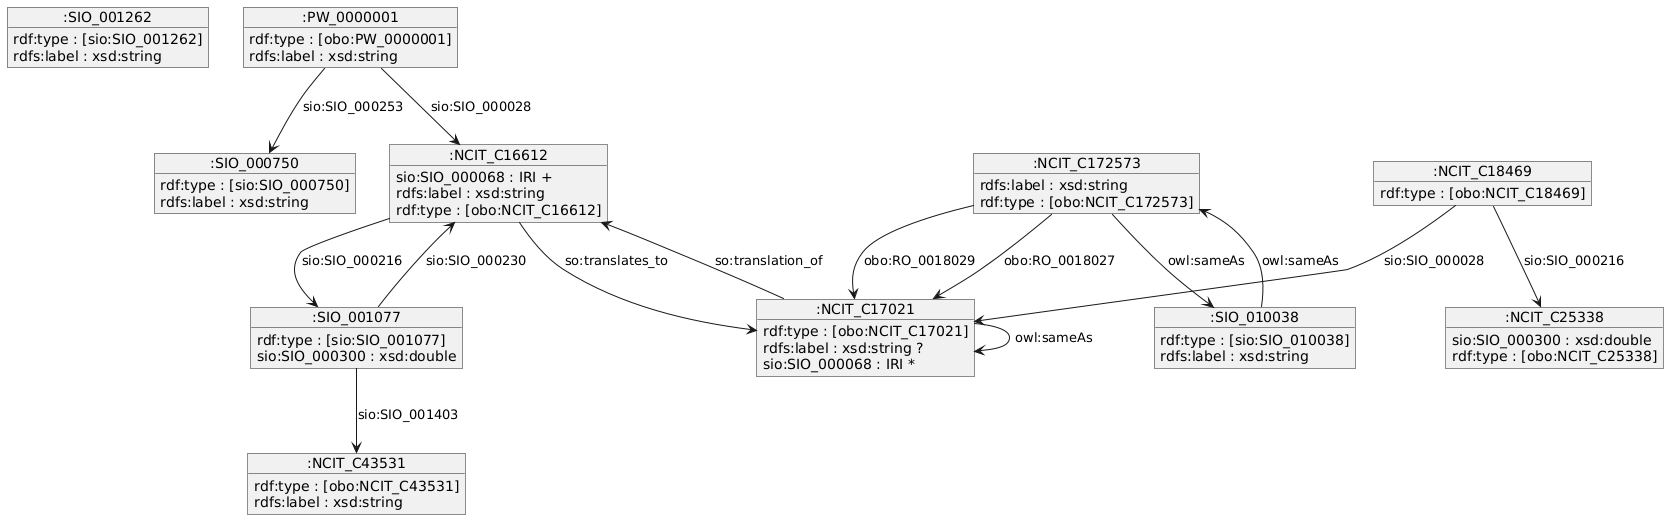

In [35]:
# Use without parameters (defaults)
bdf.shacl()
# Or Use with parameters
bdf.shacl(
    path="examples/results/gene_to_graph_workflow/BDF_example_shacl.ttl",  # Set a path to retrieve the ttl serialization in a file
    threshold=0.001,
    uml_figure_path="examples/results/gene_to_graph_workflow/BDF_example_shacl.png",  # Set a path to retrieve a diagram
)
display(Image("examples/results/gene_to_graph_workflow/BDF_example_shacl.png"))

#### ShEx

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX ex: <http://example.org/>
PREFIX : <http://weso.es/shapes/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX graph: <https://biodatafuse.org/example/>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX so: <http://purl.obolibrary.org/obo/so#>
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX qb: <h

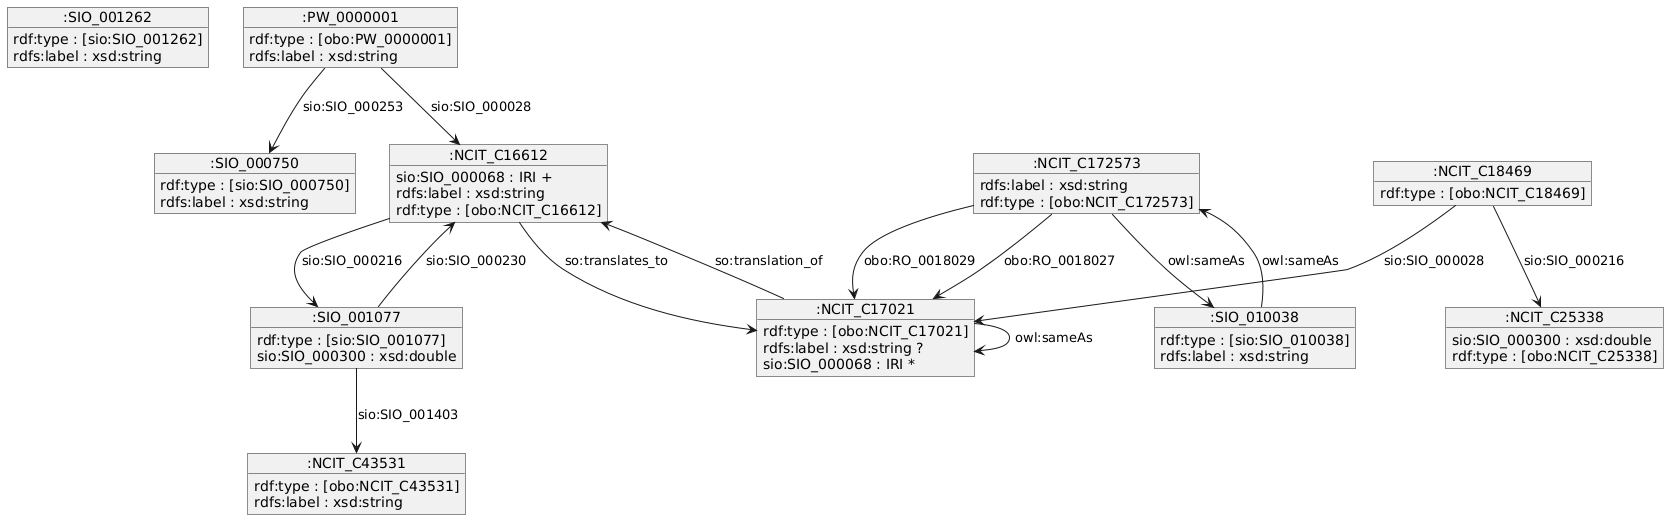

In [36]:
# Use without parameters (defaults)
bdf.shex()
# Or Use with parameters
bdf.shex(
    path="examples//results/gene_to_graph_workflow/BDF_example_shex.ttl",  #  Set a path to retrieve the ttl serialization in a file
    threshold=0.001,
    uml_figure_path="examples//results/gene_to_graph_workflow/BDF_example_shex.png",  # Set a path to retrieve a diagram
)
display(Image("examples//results/gene_to_graph_workflow/BDF_example_shex.png"))

### Elapsed time for the workflow

If ran in block.

In [37]:
end_time = time.time()
elapsed_time = end_time - start_time
hours = elapsed_time // 3600
minutes = (elapsed_time % 3600) // 60
seconds = elapsed_time % 60
milliseconds = (elapsed_time % 1) * 1000

# Display elapsed time in h:m:s:ms
print(f"Elapsed Time: {int(hours)}h {int(minutes)}m {int(seconds)}s {int(milliseconds)}ms")

Elapsed Time: 0h 4m 5s 250ms


### Set up a virtuoso endpoint to query this graph

[This repository](https://github.com/jmillanacosta/fast-virtuoso) provides a quick way to set up a local Virtuoso endpoint using its docker image.

Upload the prefixes (`bdf.shacl_prefixes(path="your/path")`) and the BDF graph generated above (`bdf.serialize("your/path", format="ttl")`).

In [38]:
# Define a function to send some sample SELECT queries and return the response in a pandas DataFrame
import requests


def send_sparql_query(query, endpoint="http://localhost:8899/sparql", format="text/csv"):
    headers = {"Accept": format}
    params = {"query": query}
    response = requests.get(endpoint, headers=headers, params=params)

    # Check if request was successful
    if response.status_code == 200:
        if format == "text/csv":
            # Convert CSV response to pandas DataFrame
            from io import StringIO

            csv_data = StringIO(response.text)
            return pd.read_csv(csv_data)
        else:
            return response.text  # For other formats if needed
    else:
        raise Exception(f"Query failed with status code {response.status_code}: {response.text}")

In [39]:
from rdflib import RDF, RDFS, SH, Graph

# Parse the query graph
# Load the graph
query_g = Graph()
with open("examples/SPARQL/queries.ttl", "r") as f:
    query_g.parse(f, format="turtle")

# Extract queries and comments into a list of dictionaries
queries_list = []
for s in query_g.subjects(RDF.type, SH.SPARQLSelectExecutable):
    query_text = query_g.value(s, SH.select)
    comment = query_g.value(s, RDFS.comment)

    if query_text and comment:
        # Append a dictionary for each query and its comment
        queries_list.append({"comment": comment.value, "query": query_text.value})

In [40]:
query_0 = send_sparql_query(queries_list[0]["query"])
print(queries_list[0]["comment"])
print(queries_list[0]["query"])
query_0

Retrieve details about each gene in the dataset, including the pathways it participates in, and the expression levels tied to it together with its associated anatomical entity and developmental stage. Return the text labels for all entities.

PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>

SELECT ?gene ?geneLabel ?pathway ?pathwayLabel ?expressionMetric ?expressionValue ?anatomicalEntity ?anatomicalEntityLabel ?developmentalStage ?developmentalStageLabel
WHERE {
    ?gene a obo:NCIT_C16612 ;
          sio:SIO_000068 ?pathway ;
          sio:SIO_000216 ?expressionMetric ;
          rdfs:label ?geneLabel .
    ?anatomicalEntity rdfs:label ?anatomicalEntityLabel ;
          a sio:SIO_001262 .
    ?developmentalStage rdfs:label ?developmentalStageLabel ;
          a obo:NCIT_C43531 .
    ?expressionMetric sio:SIO_000300 ?expressionValue ;
          sio:SIO_001403 ?anatomicalEntity ;
     

,gene,geneLabel,pathway,pathwayLabel,expressionMetric,expressionValue,anatomicalEntity,anatomicalEntityLabel,developmentalStage,developmentalStageLabel
0,http://identifiers.org/ensembl#ENSG00000172339,ALG14,https://reactome.org/content/detail/R-HSA-446193,Biosynthesis of the N-glycan precursor (dolich...,https://biodatafuse.org/example/gene_expressio...,60.1642,http://purl.obolibrary.org/obo/UBERON_0000178,blood,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
1,http://identifiers.org/ensembl#ENSG00000172339,ALG14,https://reactome.org/content/detail/R-HSA-5633231,Defective ALG14 causes ALG14-CMS,https://biodatafuse.org/example/gene_expressio...,60.1642,http://purl.obolibrary.org/obo/UBERON_0000178,blood,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
2,http://identifiers.org/ensembl#ENSG00000172339,ALG14,https://www.wikipathways.org/pathways/WP5153,N-glycan biosynthesis,https://biodatafuse.org/example/gene_expressio...,60.1642,http://purl.obolibrary.org/obo/UBERON_0000178,blood,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
3,http://identifiers.org/ensembl#ENSG00000172339,ALG14,https://reactome.org/content/detail/R-HSA-446193,Biosynthesis of the N-glycan precursor (dolich...,https://biodatafuse.org/example/gene_expressio...,73.8752,http://purl.obolibrary.org/obo/UBERON_0000310,breast,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
4,http://identifiers.org/ensembl#ENSG00000172339,ALG14,https://reactome.org/content/detail/R-HSA-5633231,Defective ALG14 causes ALG14-CMS,https://biodatafuse.org/example/gene_expressio...,73.8752,http://purl.obolibrary.org/obo/UBERON_0000310,breast,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
5,http://identifiers.org/ensembl#ENSG00000172339,ALG14,https://www.wikipathways.org/pathways/WP5153,N-glycan biosynthesis,https://biodatafuse.org/example/gene_expressio...,73.8752,http://purl.obolibrary.org/obo/UBERON_0000310,breast,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
6,http://identifiers.org/ensembl#ENSG00000172339,ALG14,https://reactome.org/content/detail/R-HSA-446193,Biosynthesis of the N-glycan precursor (dolich...,https://biodatafuse.org/example/gene_expressio...,72.1460,http://purl.obolibrary.org/obo/UBERON_0000948,heart,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
7,http://identifiers.org/ensembl#ENSG00000172339,ALG14,https://reactome.org/content/detail/R-HSA-5633231,Defective ALG14 causes ALG14-CMS,https://biodatafuse.org/example/gene_expressio...,72.1460,http://purl.obolibrary.org/obo/UBERON_0000948,heart,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
8,http://identifiers.org/ensembl#ENSG00000172339,ALG14,https://www.wikipathways.org/pathways/WP5153,N-glycan biosynthesis,https://biodatafuse.org/example/gene_expressio...,72.1460,http://purl.obolibrary.org/obo/UBERON_0000948,heart,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle
9,http://identifiers.org/ensembl#ENSG00000172339,ALG14,https://reactome.org/content/detail/R-HSA-446193,Biosynthesis of the N-glycan precursor (dolich...,https://biodatafuse.org/example/gene_expressio...,73.1451,http://purl.obolibrary.org/obo/UBERON_0000955,brain,http://purl.obolibrary.org/obo/UBERON_0000104,life cycle


In [43]:
query_3 = send_sparql_query(queries_list[3]["query"])
print(queries_list[3]["query"])
print(queries_list[3]["comment"])
query_3


PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX sio: <http://semanticscience.org/resource/>
PREFIX obo: <http://purl.obolibrary.org/obo/>

SELECT ?gene ?geneLabel ?expressionValue ?anatomicalEntity ?entityLabel
WHERE {
    ?gene a obo:NCIT_C16612 ;
          sio:SIO_000216 ?expressionMetric ;
          rdfs:label ?geneLabel .

          
    ?expressionMetric a sio:SIO_001077 ;
                      sio:SIO_001403 ?anatomicalEntity ;
                      sio:SIO_000300 ?expressionValue ;
                      sio:SIO_001403 obo:UBERON_0000104 .
    ?anatomicalEntity a sio:SIO_001262 ;
                      rdfs:label ?anatomicalEntityLabel .
}
ORDER BY DESC(?expressionValue)
List genes linked to that have been found to be expressed in blood, along with their expression level values. Sort them in descending order according to their expression level values. Return all relevant labels.


,gene,geneLabel,expressionValue,anatomicalEntity,entityLabel
0,http://identifiers.org/ensembl#ENSG00000172339,ALG14,79.6748,http://purl.obolibrary.org/obo/UBERON_0002107,NaN
1,http://identifiers.org/ensembl#ENSG00000172339,ALG14,77.9347,http://purl.obolibrary.org/obo/UBERON_0001264,NaN
2,http://identifiers.org/ensembl#ENSG00000172339,ALG14,76.0892,http://purl.obolibrary.org/obo/UBERON_0000990,NaN
3,http://identifiers.org/ensembl#ENSG00000172339,ALG14,75.6764,http://purl.obolibrary.org/obo/UBERON_0001987,NaN
4,http://identifiers.org/ensembl#ENSG00000172339,ALG14,74.3284,http://purl.obolibrary.org/obo/UBERON_0001007,NaN
5,http://identifiers.org/ensembl#ENSG00000172339,ALG14,74.0342,http://purl.obolibrary.org/obo/UBERON_0001016,NaN
6,http://identifiers.org/ensembl#ENSG00000172339,ALG14,73.8752,http://purl.obolibrary.org/obo/UBERON_0000310,NaN
7,http://identifiers.org/ensembl#ENSG00000172339,ALG14,73.4920,http://purl.obolibrary.org/obo/UBERON_0002113,NaN
8,http://identifiers.org/ensembl#ENSG00000172339,ALG14,73.2540,http://purl.obolibrary.org/obo/UBERON_0004535,NaN
9,http://identifiers.org/ensembl#ENSG00000172339,ALG14,73.1451,http://purl.obolibrary.org/obo/UBERON_0000955,NaN
